In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import os
from random import shuffle
from zipfile import ZipFile
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder


from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D

from keras.layers import MaxPooling2D
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

In [2]:
import pandas as pd
train_folder = '/content/drive/MyDrive/Datasets/small_train'
all_data = []
for folder in os.listdir(train_folder):

    label_folder = os.path.join(train_folder, folder)
    onlyfiles = [{'label':folder,'path':os.path.join(label_folder, f)} for f in os.listdir(label_folder) if os.path.isfile(os.path.join(label_folder, f))]
    #print(onlyfiles)
    all_data += onlyfiles
data_df = pd.DataFrame(all_data)
data_df

,label,path
0,A,/content/drive/MyDrive/Datasets/small_train/A/...
1,A,/content/drive/MyDrive/Datasets/small_train/A/...
2,A,/content/drive/MyDrive/Datasets/small_train/A/...
3,A,/content/drive/MyDrive/Datasets/small_train/A/...
4,A,/content/drive/MyDrive/Datasets/small_train/A/...
...,...,...
8695,space,/content/drive/MyDrive/Datasets/small_train/sp...
8696,space,/content/drive/MyDrive/Datasets/small_train/sp...
8697,space,/content/drive/MyDrive/Datasets/small_train/sp...
8698,space,/content/drive/MyDrive/Datasets/small_train/sp...


In [3]:
x_train,x_holdout = train_test_split(data_df, test_size= 0.10, random_state=42,stratify=data_df[['label']])
x_train,x_test = train_test_split(x_train, test_size= 0.25, random_state=42,stratify=x_train[['label']])

In [4]:
img_width, img_height = 64, 64
batch_size = 256
y_col = 'label'
x_col = 'path'
no_of_classes = len(data_df[y_col].unique())


train_datagen = ImageDataGenerator(rescale = 1/255.0)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=x_train,x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height),class_mode='categorical', batch_size=batch_size,
    shuffle=False,
)

validation_datagen = ImageDataGenerator(rescale = 1/255.0)
validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=x_test, x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height), class_mode='categorical', batch_size=batch_size,
    shuffle=False
)

holdout_datagen = ImageDataGenerator(rescale = 1/255.0)
holdout_generator = holdout_datagen.flow_from_dataframe(
    dataframe=x_holdout, x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height), class_mode='categorical', batch_size=batch_size,
    shuffle=False
)

Found 5872 validated image filenames belonging to 29 classes.
Found 1958 validated image filenames belonging to 29 classes.
Found 870 validated image filenames belonging to 29 classes.


In [5]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (64,64,3)))
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 128, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(29, activation = "softmax"))

In [6]:
model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 64)        0

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stop = EarlyStopping(monitor='val_loss',patience=5)

batch_size=32
epochs=20

history = model.fit(train_generator,
                    epochs=epochs,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks = [early_stop])

Epoch 1/20
23/23 [==============================] - 3285s 144s/step - loss: 3.3698 - accuracy: 0.0458 - val_loss: 3.3518 - val_accuracy: 0.0546
Epoch 2/20
23/23 [==============================] - 23s 983ms/step - loss: 3.0850 - accuracy: 0.1190 - val_loss: 2.7627 - val_accuracy: 0.1961
Epoch 3/20
23/23 [==============================] - 27s 1s/step - loss: 2.4306 - accuracy: 0.2752 - val_loss: 2.0974 - val_accuracy: 0.3289
Epoch 4/20
23/23 [==============================] - 27s 1s/step - loss: 1.8848 - accuracy: 0.4057 - val_loss: 1.6854 - val_accuracy: 0.4918
Epoch 5/20
23/23 [==============================] - 28s 1s/step - loss: 1.3463 - accuracy: 0.5690 - val_loss: 0.9932 - val_accuracy: 0.7145
Epoch 6/20
23/23 [==============================] - 22s 958ms/step - loss: 1.0266 - accuracy: 0.6637 - val_loss: 0.7964 - val_accuracy: 0.7737
Epoch 7/20
23/23 [==============================] - 23s 1s/step - loss: 0.7193 - accuracy: 0.7662 - val_loss: 0.5461 - val_accuracy: 0.8212
Epoch 8/20

In [ ]:
predictions = model.predict(holdout_generator, verbose=1)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1) #multiple categories

true_classes = holdout_generator.classes
class_labels = list(holdout_generator.class_indices.keys())
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

4/4 [==============================] - 2s 511ms/step
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        30
           B       1.00      0.97      0.98        30
           C       1.00      1.00      1.00        30
           D       1.00      1.00      1.00        30
           E       0.97      1.00      0.98        30
           F       1.00      1.00      1.00        30
           G       1.00      1.00      1.00        30
           H       1.00      1.00      1.00        30
           I       1.00      1.00      1.00        30
           J       1.00      1.00      1.00        30
           K       1.00      1.00      1.00        30
           L       1.00      1.00      1.00        30
           M       1.00      1.00      1.00        30
           N       1.00      1.00      1.00        30
           O       1.00      1.00      1.00        30
           P       1.00      1.00      1.00        30
           Q       1.00     

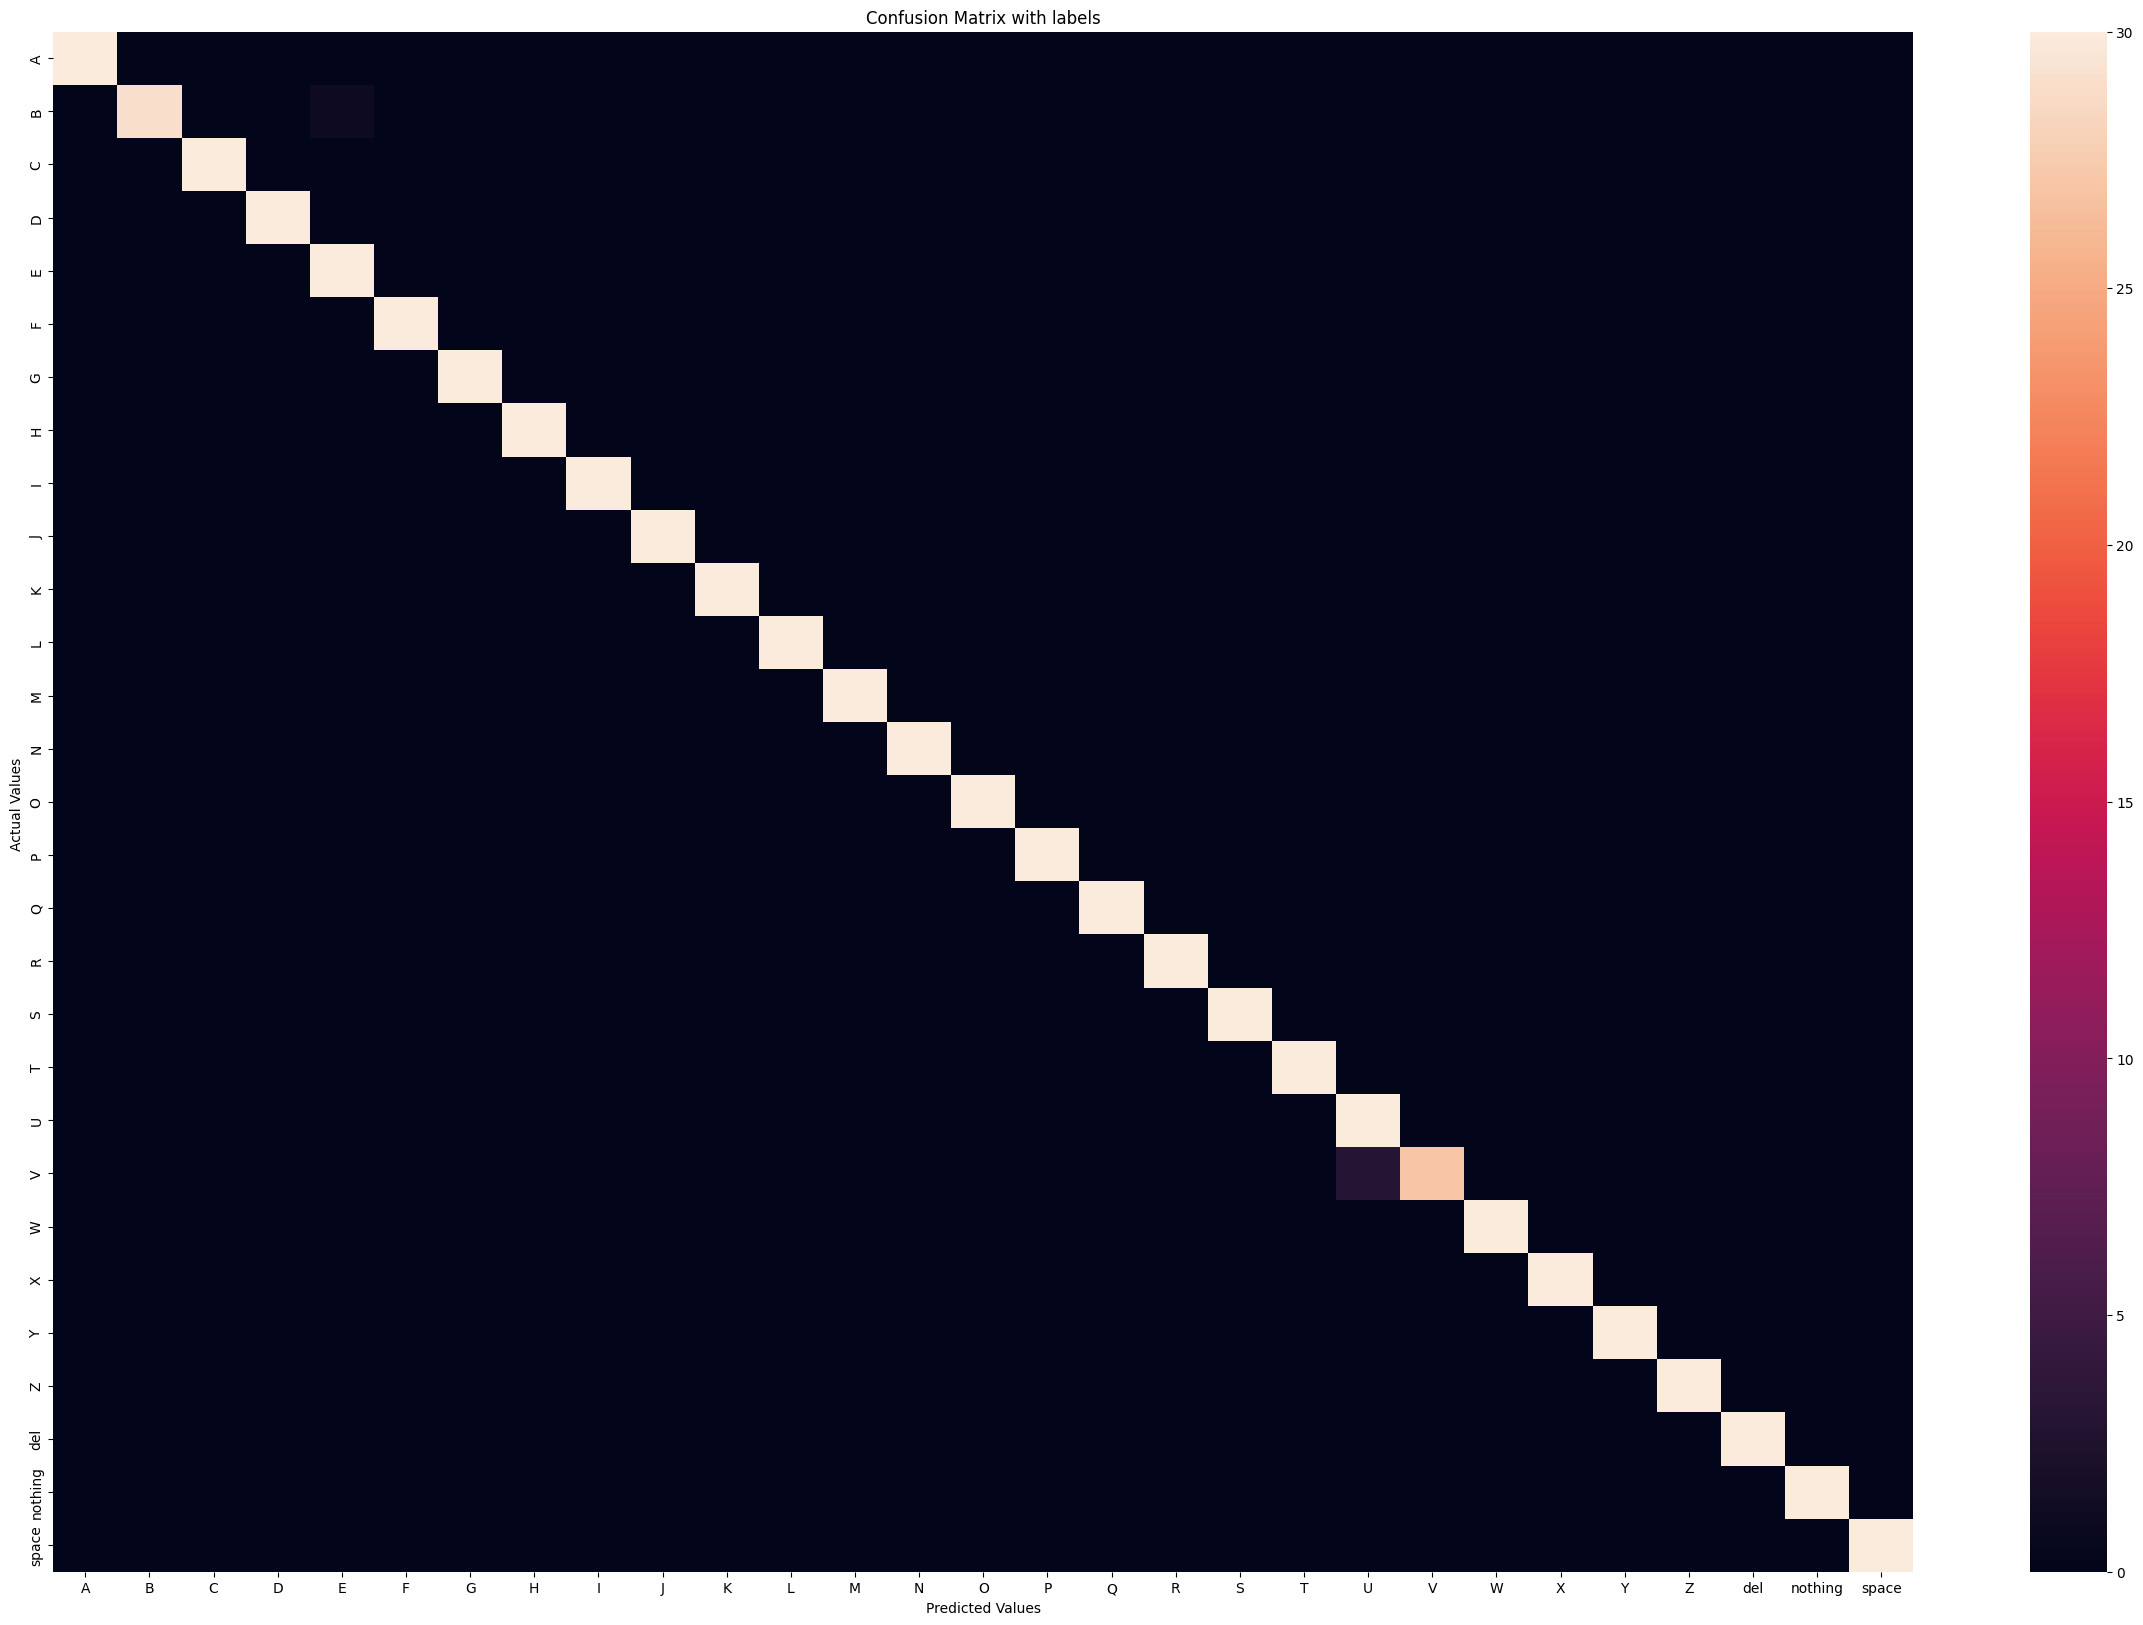

In [ ]:
plt.figure(figsize=(30, 20))

ax = sns.heatmap(metrics.confusion_matrix(true_classes,predicted_classes))
ax.set_title('Confusion Matrix with labels')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ')


## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(class_labels)
ax.yaxis.set_ticklabels(class_labels)

plt.show()

In [ ]:
model.save('ASL_classification_Better.onnx')